# Raft Results Analysis 

In [1]:
%matplotlib notebook 

import os
import re
import pytz
import json 
import glob 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from datetime import datetime

sns.set_context('notebook')
sns.set_style('whitegrid')

## Data Loading 

In [22]:
DATA = "../data/**/*.json"
RUNID = re.compile(r'metrics-(\d+).json')
DTFMT = "%Y-%m-%dT%H:%M:%S.%f"


def parse_hostname(host):
    """
    Returns the region and the PID of the host 
    """
    host = host.split("-")
    pid = int(host[-1])
    region = " ".join(host[1:-1])
    return pid, region 


def parse_datetime(dt):
    dt = dt[:-4]
    return pytz.utc.localize(datetime.strptime(dt, DTFMT))


def get_deploy(regions):
    if regions == {'virginia'}:
        return 'virginia'
    
    if regions == {'virginia', 'ohio', 'canada'}:
        return 'east coast'
    
    if regions == {'virginia', 'london', 'tokyo'}:
        return 'global'
    
    if regions == {'virginia', 'london', 'tokyo', 'mumbai', 'california'}:
        return 'global'
    
    if regions == {'virginia', 'ohio', 'california'}:
        return 'north america'
    
    if regions == {'virginia', 'ohio', 'oregon', 'california', 'canada'}:
        return 'north america'
    
    if regions == {'virginia', 'canada', 'london'}:
        return 'atlantic'
    
    if regions == {'virginia', 'canada', 'london', 'ohio', 'ireland'}:
        return 'atlantic'

    raise ValueError("unknown deploy")
    

def load_json_data(data=DATA, metric="server"):
    for path in glob.glob(data):
        
        runid = int(RUNID.search(path).groups()[0])
        host = os.path.basename(os.path.dirname(path))
        
        with open(path, 'r') as f:
            for line in f:
                row = json.loads(line)
                row["runid"] = runid 
                
                # Basic filters 
                if metric is not None and row["metric"] != metric:
                    continue 
                
                if row['throughput'] <= 0:
                    continue
                    
                regions = set([
                    parse_hostname(replica)[1] for replica in row['quorum']
                ])
                
                row['quorum'] = len(row['quorum'])
                row['deploy'] = get_deploy(regions)
                row["started"] = parse_datetime(row["started"])
                row["finished"] = parse_datetime(row["finished"])
                row["pid"], row["location"] = parse_hostname(row["replica"])
                
                yield row 
                

data = pd.DataFrame(load_json_data())

In [23]:
data.sort_values(by="runid")

,clients,commits,deploy,drops,duration,finished,location,metric,pid,quorum,replica,runid,started,throughput,version
1,10,5000,atlantic,0,7.912918711s,2018-08-10 16:12:27.144850+00:00,virginia,server,78,3,alia-virginia-78,1,2018-08-10 16:12:19.231931+00:00,631.878095,0.3.6
8,10,5000,atlantic,0,7.633028772s,2018-08-10 16:13:46.658693+00:00,virginia,server,78,5,alia-virginia-78,2,2018-08-10 16:13:39.025660+00:00,655.047970,0.3.6
9,10,5000,east coast,0,6.667818535s,2018-08-10 16:15:06.667372+00:00,virginia,server,78,3,alia-virginia-78,3,2018-08-10 16:14:59.999553+00:00,749.870437,0.3.6
4,10,5000,east coast,0,6.450961409s,2018-08-10 16:16:26.530836+00:00,virginia,server,78,5,alia-virginia-78,4,2018-08-10 16:16:20.079870+00:00,775.078269,0.3.6
7,10,4689,global,0,39.969484607s,2018-08-10 16:18:19.606761+00:00,virginia,server,78,3,alia-virginia-78,5,2018-08-10 16:17:39.637276+00:00,117.314497,0.3.6
2,10,5000,global,0,39.229558197s,2018-08-10 16:19:39.792129+00:00,virginia,server,78,5,alia-virginia-78,6,2018-08-10 16:19:00.562571+00:00,127.454915,0.3.6
3,10,5000,north america,0,6.472149024s,2018-08-10 16:20:33.864025+00:00,virginia,server,78,3,alia-virginia-78,7,2018-08-10 16:20:27.391876+00:00,772.540926,0.3.6
5,10,5000,north america,0,8.176461542s,2018-08-10 16:21:55.963511+00:00,virginia,server,78,5,alia-virginia-78,8,2018-08-10 16:21:47.787000+00:00,611.511468,0.3.6
6,10,5000,virginia,0,818.117332ms,2018-08-10 16:23:10.911154+00:00,virginia,server,78,3,alia-virginia-78,9,2018-08-10 16:23:10.093037+00:00,6111.592805,0.3.6
0,10,5000,virginia,0,1.258784984s,2018-08-10 16:24:31.823147+00:00,virginia,server,78,5,alia-virginia-78,10,2018-08-10 16:24:30.564362+00:00,3972.084243,0.3.6


## Throughput by Clients 

<IPython.core.display.Javascript object>


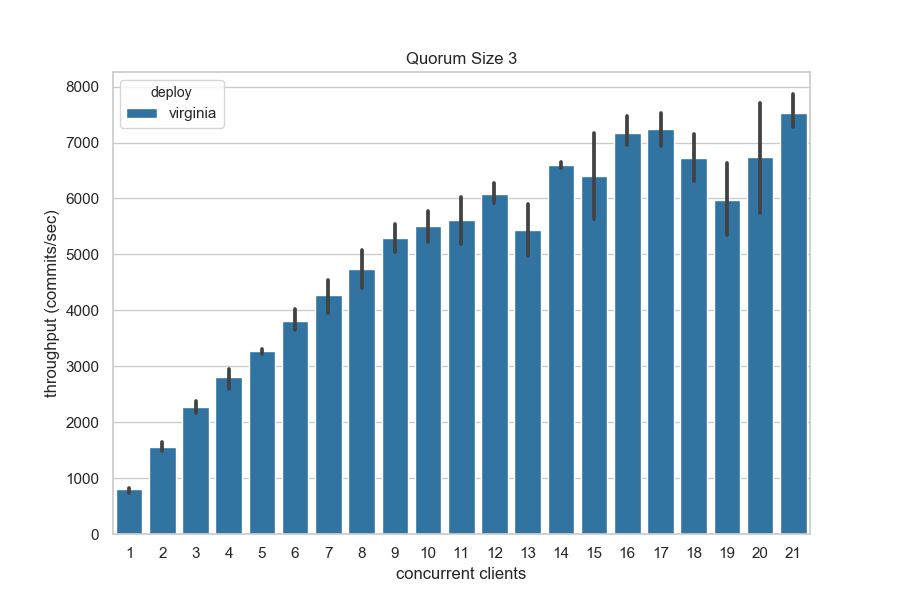

In [18]:
def plot_throughput(quorum=3, data=data, path=None):
    _, ax = plt.subplots(figsize=(9,6))
    g = sns.barplot(
        x="clients", y="throughput", hue="deploy", ax=ax,
        data=data[data['quorum'] == quorum]
    )
    
    g.set_ylabel("throughput (commits/sec)")
    g.set_xlabel("concurrent clients")
    g.set_title("Quorum Size {}".format(quorum))
    
    if path is not None:
        plt.savefig(path)
    
    return g

plot_throughput(3, path="throughput-3.pdf")

<IPython.core.display.Javascript object>


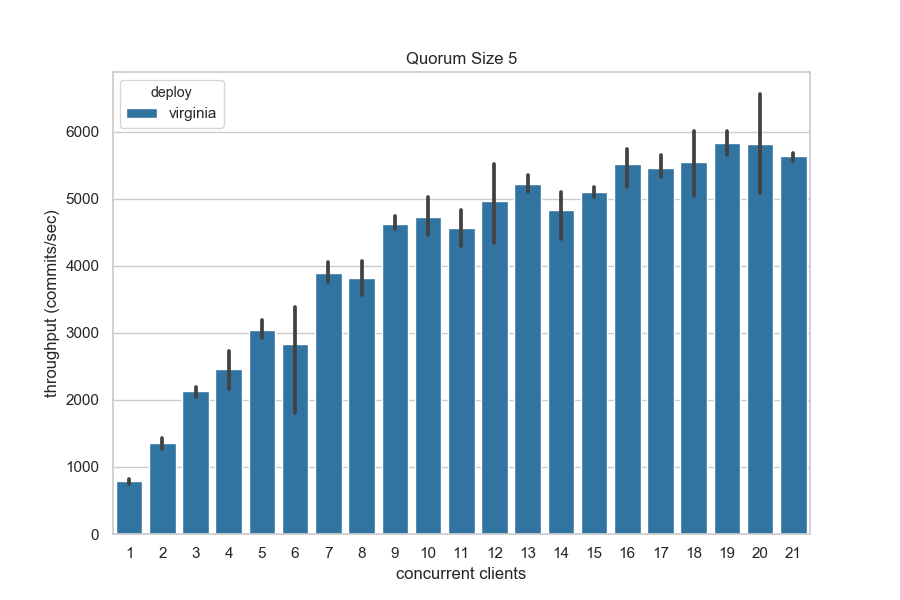

In [19]:
plot_throughput(5, path="throughput-5.pdf")

<IPython.core.display.Javascript object>


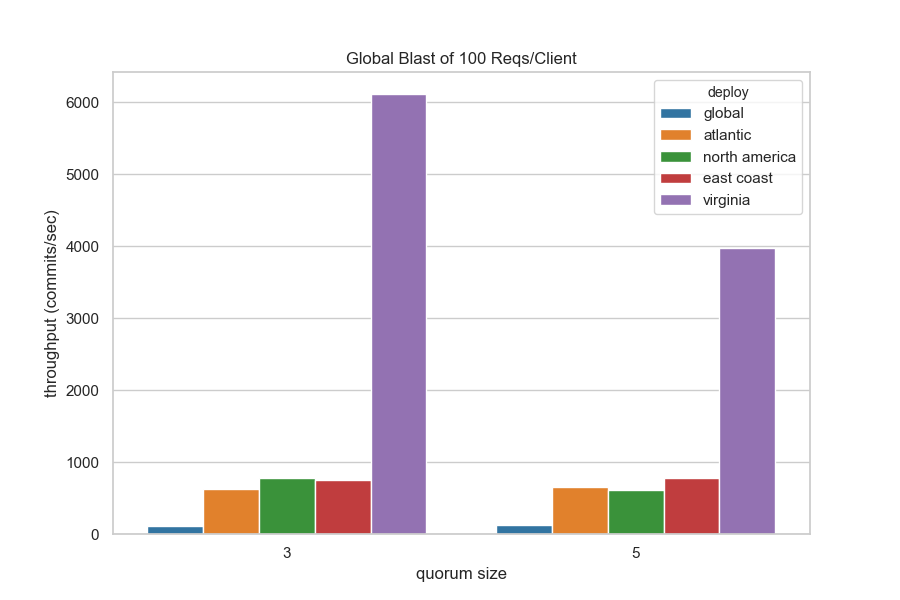

In [24]:
hue_order = ['global', 'atlantic', 'north america', 'east coast', 'virginia']
_, ax = plt.subplots(figsize=(9,6))

g = sns.barplot(
    x="quorum", y="throughput", hue="deploy", ax=ax, data=data, hue_order=hue_order,
)

g.set_ylabel("throughput (commits/sec)")
g.set_xlabel("quorum size")
g.set_title("Client Colocated with Leader")

plt.savefig("global-100-blast.pdf")

<IPython.core.display.Javascript object>


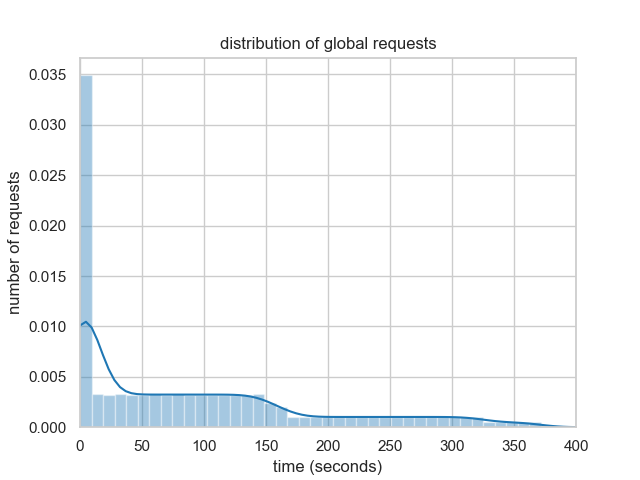

In [2]:
# 17 clients, leader in VA 

# latency  (mean, std)
latency = {
    "virginia" : (  4.34,  1.88),
    "oregon"   : (166.80,  9.76),
    "london"   : (151.80,  1.53),
    "tokyo"    : (326.14, 14.79),
    "mumbai"   : (371.94,  1.05),
}


def requests(mean, std, num=1000):
    ts = 0.0 
    for _ in range(num):        
        yield ts 
        ts += np.random.normal(mean, std)

        
def plot_request_distribution(path=None):
    data = np.array([
        list(requests(*dist))
        for loc, dist in latency.items()
        for _ in (range(5) if loc == 'virginia' else range(3))
    ])

    g = sns.distplot(data.ravel()/1000, bins=40, norm_hist=True)
    g.set_ylabel("number of requests")
    g.set_xlabel("time (seconds)")
    g.set_title("distribution of global requests")
    g.set_xlim(0,400)
    
    if path is not None:
        plt.savefig(path)
    
    return g

plot_request_distribution()